In [12]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import numpy as np
from tqdm import tqdm_notebook as tqdm
import logging
from cost import SquaredError, CrossEntropy


def identity(x, deriv=False):
    if deriv:
        return 1
    return x


def sigmoid(x, deriv=False):
    if deriv:
        return x * (1-x)
    return 1 / (1 + np.exp(-x))


def softmax(x, deriv=False, axis=1):
    shift_x = x - np.max(x)
    
    try:
        sm = np.exp(shift_x) / np.sum(np.exp(shift_x), axis=axis, keepdims=True)
    except np.AxisError:
        sm = np.exp(shift_x) / np.sum(np.exp(shift_x), axis=None, keepdims=True)
        
    if deriv: 
        return x * (1 - x) # https://datascience.stackexchange.com/questions/29735/how-to-apply-the-gradient-of-softmax-in-backprop
    else:
        return sm

In [13]:
predictions = np.array([0.1, 0.1, 0.8])
targets = np.array([0, 0, 1])
cost = CrossEntropy()
cost.error(predictions, targets)

0.43386458262986227

In [59]:
class NeuralNetwork:
    
    # Class Attributes
    train_error = list()
    
    def __init__(self, layers, cost_function):
        assert isinstance(layers, list), "Input needs to be a list of Layers"
        assert len(layers) > 1, "Input needs to be a list of at least two Layers"
        self.layers = layers
        self.x = np.zeros(1)
        self.target = np.zeros(1)
        self.current_state = np.zeros(1)
        assert callable(cost_function), "Chose a valid error function"
        self.cost_function = cost_function
        self.l_error = list() # Error over time is saved here

                
    def load_data(self, x: np.ndarray, target: np.ndarray):
        # Check if input and output have the same amount of cases 
        assert len(x) == len(target), f"Input and target output contain a different number of cases ({len(x)} vs. {len(target)})"
        # Check if x and target are numeric numpy arrays
        assert np.issubdtype(x.dtype, np.number) & np.issubdtype(target.dtype, np.number), "Both input and target need to be numeric arrays"
        
        self.x = x.copy()
        self.target = target.copy()
        
    
    def init_weights(self):
        # First we infer the input size for each of the layer, except the first one
        for i, layer in enumerate(self.layers):
            if i == 0:
                assert layer.input_size, "The first layer need to be initialized with the parameter 'input_size'"
            else:
                layer.input_size = self.layers[i-1].size

        # Initialize the weights with random noise
        np.random.RandomState(42)
        sigma = 0.03
        
        # Then we initialize the weights by using the input size (+1 bias Unit) and amount of units
        for layer in self.layers:
            layer.weights = sigma * np.random.randn(layer.input_size + 1, layer.size)
    
    
    def train(self, n_epochs: int, alpha=0.01):
        for epoch in tqdm(range(n_epochs)):
            # Calculate forward
            self.current_state = self.calc_output(self.x)
            
            error_epoch = self.cost_function(self.current_state, self.target)
            logging.debug(f"Error in epoch {epoch}: {error_epoch}")
            self.l_error.append(error_epoch)
                    
            # Calculate backwards
            # Start with calculating the error/loss at each layer            
            for i, layer in enumerate(reversed(self.layers)):
                if i == 0:
                    layer.error = np.subtract(self.current_state, self.target)
                    # Start with calculating the error/loss at the output
                else:
                    layer.calc_error(prev_error=self.layers[len(self.layers) - i].error, prev_weights=self.layers[len(self.layers) - i].weights)
            
            # Then calculate the partial derivative and update the weights
            for layer in self.layers:
                layer.update_weights(alpha)
                
    def train_sgd(self, n_epochs: int, alpha=0.01):
        for epoch in tqdm(range(n_epochs)):
            # Shuffle the examples in the beginning of each epoch:
            self.x, self.target = unison_shuffled_copies(self.x, self.target)
            for i_step, example in enumerate(self.x):
                # Calculate forward
                self.current_state = example
                for layer in self.layers:
                    layer.forward(self.current_state)
                    self.current_state = layer.activations_out

                mse_epoch = mse(self.current_state, self.target[i_step])
                self.l_error.append(mse_epoch)
                #if not (epoch % 10):
                #    if mse_epoch > (min(self.l_error) * 1.1):
                #        alpha = alpha/2
                #        print("Devide alpha by 2")

                # Calculate backwards
                # Start with calculating the error/loss at each layer            
                for i, layer in enumerate(reversed(self.layers)):
                    if i == 0:
                        layer.error = np.subtract(self.current_state, self.target[i_step])
                        # Start with calculating the error/loss at the output
                    else:
                        layer.calc_error(prev_error=self.layers[len(self.layers) - i].error, prev_weights=self.layers[len(self.layers) - i].weights)

                # Then calculate the partial derivative and update the weights
                for layer in self.layers:
                    layer.update_weights(alpha)
                
    def plot_error(self):
        plt.plot(range(len(self.l_error)), self.l_error)
        plt.show()
        
    
    def calc_output(self, _input):
        # Calculate 
        current_state = _input
        for layer in self.layers:
            layer.forward(current_state)
            current_state = layer.activations_out
        return current_state
    

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [98]:
class Layer:
    
    def __init__(self, size: int, activation, input_size=False):
        assert isinstance(size, int), "The number of nodes needs to be of type int"
        self.size = size
        assert callable(activation), "Chose a valid activation function"
        self.activation = activation
        self.activations_in = np.zeros(1)
        self.activations_out = np.zeros(size)
        self.error = np.zeros(size)
        self.weights = np.zeros(size)
        self.isfirst = False
        self.input_size = input_size
        if input_size:
            self.isfirst = True
        
    def __len__(self):
        return self.size


class Dense(Layer):

    def forward(self, activations_in):
        # Save incoming activations for later backpropagation and add bias unit
        if activations_in.ndim == 1:
            ones_shape = 1
        else:
            ones_shape = (len(activations_in), 1) + activations_in.shape[2:]
        self.activations_in = np.hstack((np.ones(shape=ones_shape), activations_in))
        self.activations_out = self.activation(np.dot(self.activations_in, self.weights)) 

    def calc_error(self, prev_error, prev_weights):
        self.error = np.dot(prev_error, prev_weights.T[:, 1:]) * self.activation(self.activations_out, deriv=True)
    
    def update_weights(self, alpha):
        # The first layer does have one weight less due to the missing bias unit
        # Calculate the partial derivatives for the Error in respect to each weight
        if self.isfirst:
            if self.activations_in.ndim == 1:
                partial_derivative = self.activations_in[:, np.newaxis] * self.error[np.newaxis, :]
                gradient = partial_derivative
            else:
                partial_derivative = self.activations_in[:, :1, np.newaxis] * self.error[: , np.newaxis, :]
                gradient = np.average(partial_derivative, axis=0)
        else:
            if self.activations_in.ndim == 1:
                partial_derivative = self.activations_in[:, np.newaxis] * self.error[np.newaxis, :]
                gradient = partial_derivative
            else:
                partial_derivative = self.activations_in[:, :1, np.newaxis] * self.error[: , np.newaxis, :]
                gradient = np.average(partial_derivative, axis=0)
        print(f"Weights before update: {self.weights}")
        self.weights += -alpha * gradient
        print(f"Weights after update: {self.weights}")
        

def batch_gd(weights, alpha, gradient):
    return -alpha * gradient + weights
    

def stochastic_gd():
    pass

    
def mini_batch_gd():
    pass

    
class Activision(Layer):
    
    def forward(self, activations_in):
        self.activations_out = self.activation(np.dot(activations_in, weights))
        
    def backward(self):
        pass                             


In [99]:
class Optimizer:
    pass

class SGD(Optimizer):
    def __init__(self, batch_size, momentum=0.9):
        pass
        
    def gradient_decent(self, weights, gradient, learning_rate=0.03):
        return weights - learning_rate * gradient
    
    def momentum(self, gradient, rate=0.9):
        pass
        
    
        
        

In [100]:
logging.basicConfig(level='DEBUG')

data = load_iris()
x = data['data']
target = data['target']

# One-Hot-Encoding the output (since its categorical)
n_categories = 3
y = np.eye(n_categories)[target.astype(int)]

#x, y = unison_shuffled_copies(x, y)

nn = NeuralNetwork([Dense(6, sigmoid, input_size=4), Dense(3, softmax)], cost_function=CrossEntropy())
nn.load_data(x, y)
nn.init_weights()

nn.train(2, alpha=0.03)

DEBUG:root:Error in epoch 0: 1.0990783740452996


Weights before update: [[-0.02772367 -0.00646534  0.04736221 -0.00926015 -0.01555423 -0.01192202]
 [ 0.03469633 -0.00716856  0.03361314 -0.05712703 -0.03408224  0.01645625]
 [-0.01760202 -0.00697929  0.01390461 -0.03583611 -0.03641061 -0.00173555]
 [-0.00779518 -0.02259188 -0.00956332 -0.03349424  0.00338069 -0.04870029]
 [-0.0401065  -0.01818815  0.03282993 -0.00487407  0.00055935  0.01231794]]
Weights after update: [[-0.02772183 -0.00646467  0.04735751 -0.0092579  -0.01556396 -0.01192069]
 [ 0.03469818 -0.00716788  0.03360843 -0.05712479 -0.03409197  0.01645758]
 [-0.01760018 -0.00697861  0.0138999  -0.03583387 -0.03642034 -0.00173422]
 [-0.00779333 -0.0225912  -0.00956802 -0.033492    0.00337097 -0.04869896]
 [-0.04010466 -0.01818747  0.03282522 -0.00487182  0.00054962  0.01231928]]
Weights before update: [[-0.03020193  0.0417787   0.02946888]
 [ 0.01516391  0.03478377 -0.00293758]
 [ 0.02538204  0.01346112  0.02126862]
 [-0.00395031 -0.00966606  0.03414918]
 [ 0.03866099 -0.0112360

DEBUG:root:Error in epoch 1: 1.0990001889779002


Weights before update: [[-0.02772183 -0.00646467  0.04735751 -0.0092579  -0.01556396 -0.01192069]
 [ 0.03469818 -0.00716788  0.03360843 -0.05712479 -0.03409197  0.01645758]
 [-0.01760018 -0.00697861  0.0138999  -0.03583387 -0.03642034 -0.00173422]
 [-0.00779333 -0.0225912  -0.00956802 -0.033492    0.00337097 -0.04869896]
 [-0.04010466 -0.01818747  0.03282522 -0.00487182  0.00054962  0.01231928]]
Weights after update: [[-0.02771995 -0.00646389  0.04735309 -0.00925553 -0.01557322 -0.01191928]
 [ 0.03470006 -0.0071671   0.03360401 -0.05712242 -0.03410123  0.01645899]
 [-0.0175983  -0.00697783  0.01389548 -0.0358315  -0.0364296  -0.0017328 ]
 [-0.00779145 -0.02259042 -0.00957244 -0.03348963  0.00336171 -0.04869755]
 [-0.04010278 -0.01818669  0.0328208  -0.00486945  0.00054037  0.01232069]]
Weights before update: [[-0.02969383  0.04173172  0.02900776]
 [ 0.01567201  0.03473679 -0.0033987 ]
 [ 0.02589014  0.01341414  0.0208075 ]
 [-0.00344221 -0.00971303  0.03368806]
 [ 0.03916909 -0.0112830

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


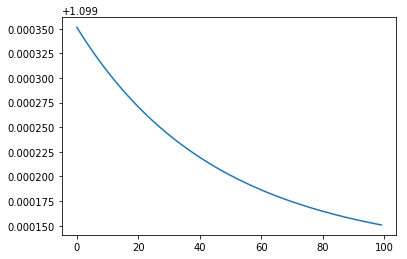

In [92]:
nn.plot_error()

In [93]:
nn.calc_output(x)

array([[0.33078614, 0.33495947, 0.33425439],
       [0.33089411, 0.33492147, 0.33418442],
       [0.33085633, 0.33491245, 0.33423123],
       [0.33092847, 0.33484929, 0.33422224],
       [0.33077844, 0.33494359, 0.33427797],
       [0.33075835, 0.33489391, 0.33434774],
       [0.33085602, 0.33484916, 0.33429482],
       [0.33083589, 0.33491912, 0.33424499],
       [0.33096133, 0.33483656, 0.33420211],
       [0.33089592, 0.33492525, 0.33417883],
       [0.33074347, 0.33498872, 0.33426781],
       [0.33087796, 0.33486287, 0.33425917],
       [0.33090121, 0.33493028, 0.33416851],
       [0.33088374, 0.3349145 , 0.33420176],
       [0.33058496, 0.33512597, 0.33428907],
       [0.33059688, 0.33499343, 0.33440969],
       [0.33066972, 0.33498456, 0.33434572],
       [0.33078896, 0.33493387, 0.33427716],
       [0.3307433 , 0.33496877, 0.33428793],
       [0.33075842, 0.3349138 , 0.33432778],
       [0.33084066, 0.33494073, 0.33421861],
       [0.33077882, 0.33488734, 0.33433384],
       [0.